In [1]:
import os
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [4]:
# ! kaggle competitions download -c cassava-leaf-disease-classification


In [5]:
# import zipfile
# import os

# # Path to your downloaded ZIP file
# zip_file_path = "cassava-leaf-disease-classification.zip"
# extract_dir = "./cassava-leaf-disease"

# # Extract the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print("Extraction complete!")


In [2]:
label_to_disease = pd.read_json('./cassava-leaf-disease/label_num_to_disease_map.json', typ='series')

## Data Prep

### Preprocessing

In [3]:
train_csv = pd.read_csv('./cassava-leaf-disease/train.csv')

train_csv['disease'] = train_csv['label'].map(label_to_disease)
train_csv['path'] = './cassava-leaf-disease/train_images/' + train_csv['image_id']
train_csv.head()

,image_id,label,disease,path
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB),./cassava-leaf-disease/train_images/1000015157...
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD),./cassava-leaf-disease/train_images/1000201771...
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD),./cassava-leaf-disease/train_images/100042118.jpg
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD),./cassava-leaf-disease/train_images/1000723321...
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD),./cassava-leaf-disease/train_images/1000812911...


### Checking for null values

In [4]:
print(train_csv.isnull().sum())


image_id    0
label       0
disease     0
path        0
dtype: int64


### One hot label encoding

In [5]:
from sklearn.preprocessing import LabelEncoder
train_csv['label_encoded'] = LabelEncoder().fit_transform(train_csv['disease'])

# print new encoded labels
train_csv.head()


,image_id,label,disease,path,label_encoded
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB),./cassava-leaf-disease/train_images/1000015157...,0
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD),./cassava-leaf-disease/train_images/1000201771...,3
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD),./cassava-leaf-disease/train_images/100042118.jpg,1
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD),./cassava-leaf-disease/train_images/1000723321...,1
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD),./cassava-leaf-disease/train_images/1000812911...,3


### Class Imbalance

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [7]:
# check if tensorflow keras is properly installed
print(tf.keras.__version__)

3.6.0


Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


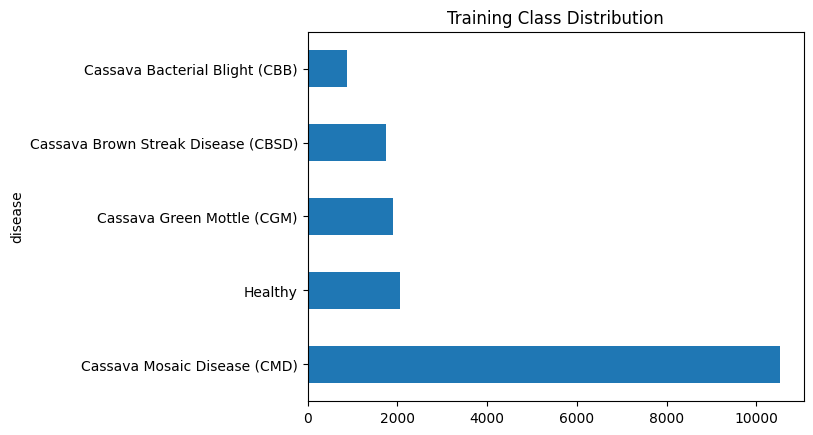

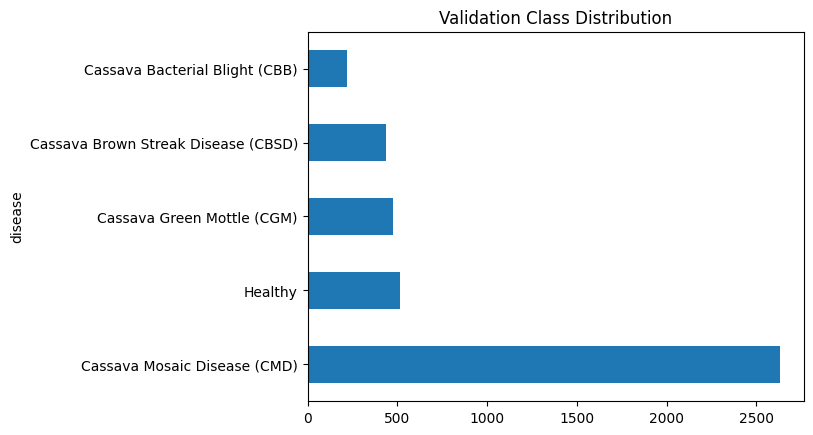

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Convert 'disease' and 'label' columns to string type
train_csv['disease'] = train_csv['disease'].astype(str)
train_csv['label'] = train_csv['label'].astype(str)

# Split the data into train and validation sets with stratified sampling
train, valid = train_test_split(train_csv, test_size=0.2, stratify=train_csv['label'])

# Data augmentation and preprocessing for training
datagen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator for the training set
train_generator = datagen_aug.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='disease',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator for the validation set without augmentation
datagen_valid = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_generator = datagen_valid.flow_from_dataframe(
    dataframe=valid,
    x_col='path',
    y_col='disease',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Plot the class distribution for the training set
train['disease'].value_counts().plot(kind='barh')
plt.title('Training Class Distribution')
plt.show()

# Plot the class distribution for the validation set
valid['disease'].value_counts().plot(kind='barh')
plt.title('Validation Class Distribution')
plt.show()


## Import models

In [10]:
import tensorflow_hub as hub

# Re-load the model from TensorFlow Hub
model_url = 'https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2'
cropnet_classifier = hub.KerasLayer(model_url, trainable=True)
model_cropnet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)), 
    tf.keras.layers.Lambda(lambda x: cropnet_classifier(x))
])


In [11]:
import torch
from torchvision import models
# Load the DenseNet-169 model
denseNet169_model = models.densenet169(pretrained=True)

c:\Users\alici\OneDrive - Nanyang Technological University\Y3S1\SC4000\Assignment\SC4000-Leaf-Project\sc4000_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\OneDrive - Nanyang Technological University\Y3S1\SC4000\Assignment\SC4000-Leaf-Project\sc4000_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169

# Load the pre-trained DenseNet-169 model
base_model = DenseNet169(
    include_top=False,  # Exclude the original classification head
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the DenseNet-169 base
model_densenet = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')  # Adjust output classes for your problem
])


# Machine Learning

In [13]:
# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Plain Crop Net

In [14]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # Assuming the images are JPEGs
    image = tf.image.resize(image, [224, 224])  # Resize to the expected input size
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train['path'].values, train['label_encoded'].values))
valid_ds = tf.data.Dataset.from_tensor_slices((valid['path'].values, valid['label_encoded'].values))

# Map the loading and preprocessing function to the datasets
train_ds = train_ds.map(load_and_preprocess_image).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(load_and_preprocess_image).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



In [15]:
# check train_ds
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)
    

(32, 224, 224, 3)
(32,)


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    patience=2, 
    factor=0.5, 
    min_lr=1e-6, 
    verbose=1
)


In [ ]:
model_cropnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_cropnet = model_cropnet.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[early_stopping, learning_rate_reduction]
)






In [41]:
# save the model
model_cropnet.save('model_cropnet.h5')

In [18]:
# run test images
test_images = tf.data.Dataset.list_files('./cassava-leaf-disease/test_images/*.jpg')
test_images = test_images.map(lambda x: (x, tf.zeros_like(x)))

# Map the loading and preprocessing function to the datasets
test_ds = test_images.map(load_and_preprocess_image).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# get the predictions
test_preds = model_cropnet.predict(test_ds)

# get the predicted labels
test_preds = np.argmax(test_preds, axis=1)

# get the image ids
image_ids = [image[0].numpy().decode('utf-8').split('/')[-1] for image in test_images]

# create a dataframe
submission = pd.DataFrame({'image_id': image_ids, 'label': test_preds})

submission

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


,image_id,label
0,.\cassava-leaf-disease\test_images\2216849948.jpg,2


In [ ]:
model_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_densenet = model_densenet.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[early_stopping, learning_rate_reduction]
)

# save the model
model_densenet.save('model_densenet.h5')

## Use Cropnet as feature extractor

- dense net as feature extractor generates symbolic tensor mismatch
- cropnet generate embeddings => easier
- then use custom denese layers similar to densenet classification head on top of cropnet extracted features



In [45]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# load cropnet model for feature extraction
model_url = 'https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2'
cropnet_classifier = hub.KerasLayer(model_url, trainable=False)

# load the model
cropnet_feature_extractor = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Lambda(lambda x: cropnet_classifier(x))
])

# define input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
cropnet_features = cropnet_feature_extractor(input_layer)


In [48]:
# add densenet inspired layers
x = Dense(512, activation='relu')(cropnet_features)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  # Adjust number of classes

# Create the combined model
model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,453 (658.02 KB)

 Trainable params: 168,453 (658.02 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# train the model
history_feature_extraction = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[early_stopping, learning_rate_reduction]
)

# evaluate the model
model.evaluate(valid_ds)



Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 135s 244ms/step - accuracy: 0.8294 - loss: 0.9033 - val_accuracy: 0.8780 - val_loss: 0.3703 - learning_rate: 1.0000e-04
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 127s 237ms/step - accuracy: 0.8842 - loss: 0.3658 - val_accuracy: 0.8801 - val_loss: 0.3649 - learning_rate: 1.0000e-04
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 117s 219ms/step - accuracy: 0.8843 - loss: 0.3607 - val_accuracy: 0.8804 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 114s 214ms/step - accuracy: 0.8853 - loss: 0.3566 - val_accuracy: 0.8808 - val_loss: 0.3557 - learning_rate: 1.0000e-04
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 114s 214ms/step - accuracy: 0.8860 - loss: 0.3528 - val_accuracy: 0.8804 - val_loss: 0.3516 - learning_rate: 1.0000e-04
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 116s 217ms/step - accuracy: 0.8867 - loss: 0.3491 - val_accuracy: 0.8811 - val_loss: 0.3476 - learning_rate: 1.0000e-04
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 

[0.3358863890171051, 0.8822429776191711]

In [50]:
# get validation accuracy
val_acc = history_feature_extraction.history['val_accuracy'][-1]
print(f'Validation accuracy: {val_acc:.2f}')

Validation accuracy: 0.88


In [51]:
# save the model
model.save('model_feature_extraction.h5')


## Densenet169 pytorch

In [40]:
# Freeze all layers
for param in denseNet169_model.parameters():
    param.requires_grad = False

# Modify the classifier (last layer)
denseNet169_model.classifier = torch.nn.Linear(
    in_features=denseNet169_model.classifier.in_features, 
    out_features=5, 
    bias=True
)

# Enable training only for the last layer
for param in denseNet169_model.classifier.parameters():
    param.requires_grad = True


In [53]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CassavaDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.annotations.iloc[idx, 1])  # Get label as int

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split the data into train and validation sets with stratified sampling
train_df, valid_df = train_test_split(train_csv, test_size=0.2, stratify=train_csv['label'])


train_dataset = CassavaDataset(
    df=train_df,
    root_dir='cassava-leaf-disease/train_images',
    transform=transform
)

valid_dataset = CassavaDataset(
    df=valid_df,
    root_dir='cassava-leaf-disease/train_images',
    transform=transform
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

In [44]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(denseNet169_model.parameters(), lr=0.001)

early_stopping = EarlyStopper(patience=3, min_delta=0.001)




In [45]:
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
denseNet169_model = denseNet169_model.to(device)


In [ ]:

# Train the model
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs}')

    denseNet169_model.train()  # Set the model to training mode

    for images, labels in train_loader:
        # Move images and labels to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = denseNet169_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Early stopping monitoring (if applicable)
        early_stopping.early_stop(loss.item())

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')




In [54]:
# Test the model
denseNet169_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        # Move images and labels to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = denseNet169_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 78.83177570093459%


### VIT

In [81]:
!pip install transformers

     --------------------------------------- 10.0/10.0 MB 11.2 MB/s eta 0:00:00
     ------------------------------------- 447.5/447.5 kB 14.1 MB/s eta 0:00:00
     -------------------------------------- 162.0/162.0 kB 9.5 MB/s eta 0:00:00
     -------------------------------------- 274.0/274.0 kB 8.2 MB/s eta 0:00:00
     ------------------------------------- 286.0/286.0 kB 17.2 MB/s eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 11.7 MB/s eta 0:00:00
     ---------------------------------------- 78.3/78.3 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
vit_model_url = "google/vit-base-patch16-224"
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Load the ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_url)
model_vit = ViTForImageClassification.from_pretrained(vit_model_url)



c:\Users\alici\OneDrive - Nanyang Technological University\Y3S1\SC4000\Assignment\SC4000-Leaf-Project\sc4000_env\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Ensemble learning - weighted average

In [55]:
# save both models
model_densenet.save('model_densenet.h5')
model_cropnet.save('model_cropnet.h5')



In [77]:
# load the models

model_densenet = tf.keras.models.load_model('model_densenet.h5')
model_cropnet = tf.keras.models.load_model('model_cropnet.h5')



In [ ]:
def voting_ensemble(models, test_loader):
    # Set models to evaluation mode
    for model in models
        model.eval()

    # Make predictions
    predictions = []
    